# Fitz Hugh Nagumo Neuron Model

Computation of trajectory for $(u, w)$ is given by

$$
\frac{du}{dt} = u -\frac{u^3}{3} - w + I
$$

and 

$$
\frac{dw}{dt} = \epsilon (b_0 + b_1 u - w)
$$

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
%matplotlib inline

In [8]:
ϵ = 0.1
b0 = 2.
b1 = 1.5

dudt = lambda U,W,I : U - U**3 / 3 - W + I
dwdt = lambda U,W : ϵ * (b0 + b1 * U - W)

def compute_trajectory(u0, w0, I, steps, dt):
    uu = [u0]
    ww = [w0]
    
    for t in range(steps):
        uu.append(uu[-1] + dudt(uu[-1], ww[-1], I) * dt)
        ww.append(ww[-1] + dwdt(uu[-1], ww[-1]) * dt)
        
    return np.array(uu), np.array(ww)

Plot derivatives at each location, zero curves as well as trajectories for different input currents.

In [9]:
def trajectory_plot(I = 2):
    w_u0 = lambda u : (u - u**3 / 3 + I)
    u_u0 = lambda u : b0 + b1 * u

    U, W = np.meshgrid(np.arange(-3, 3, .5), np.arange(-3, 5, .5))
    dU = dudt(U,W,I)
    dW = dwdt(U,W)

    # Quiver Plot
    plt.figure()
    Q = plt.quiver(U,W,dU, dW, width=0.003, scale=100)
    qk = plt.quiverkey(Q, 0, 0, 3, r'$\dot x$', labelpos='N',
                       fontproperties={'weight': 'bold'})
    l, r, b, t = plt.axis()
    dx, dy = r - l, t - b
    plt.axis([-3,3,-3,5])

    # Zero Lines
    uu = np.linspace(-3,3,100)
    plt.plot(uu, w_u0(uu))
    plt.plot(uu, u_u0(uu))

    # Trajectory
    uu, ww = compute_trajectory(-2,-2,I,10000,0.01)
    plt.plot(uu, ww)

    plt.xlabel(r"$u$")
    plt.ylabel(r"$w$")

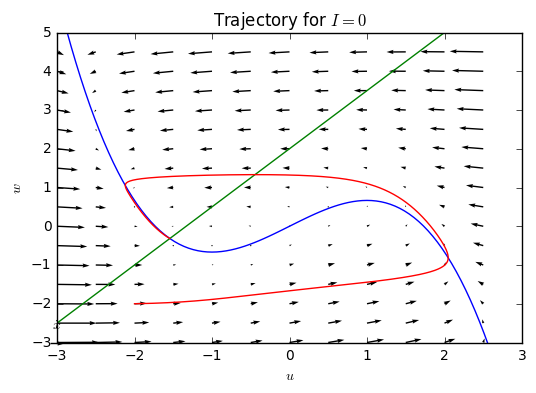

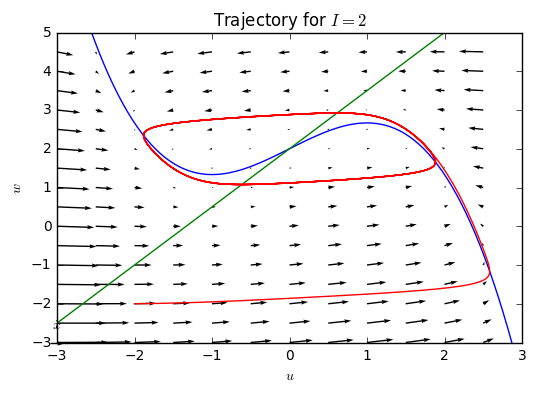

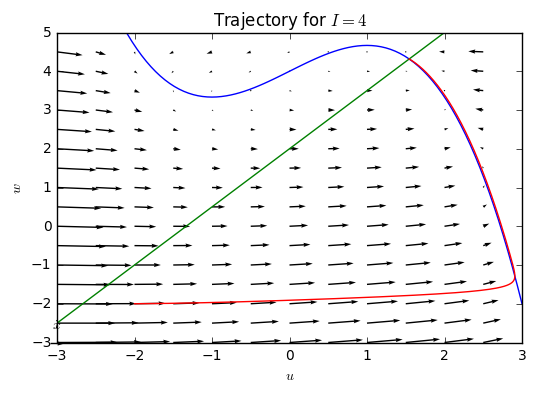

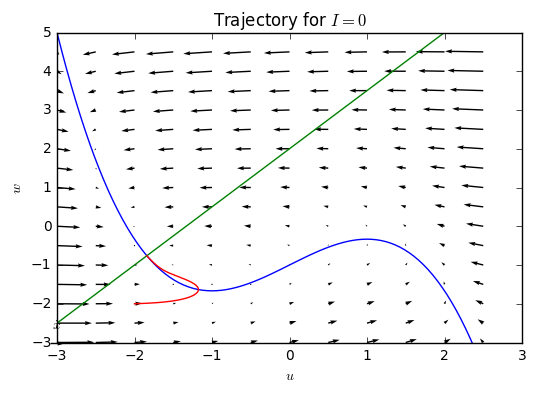

In [10]:
trajectory_plot(I=0)
plt.title(r"Trajectory for $I=0$")
plt.show()

trajectory_plot(I=2)
plt.title(r"Trajectory for $I=2$")
plt.show()

trajectory_plot(I=4)
plt.title(r"Trajectory for $I=4$")
plt.show()

trajectory_plot(I=-1)
plt.title(r"Trajectory for $I=0$")
plt.show()

# Comparison to the reduced Hodkin Huxley model

In [29]:
# Offset voltage level
u_off = -65

# Sodium: m³ is probability, h gating variable
α_m = lambda u: (2.5 - 0.1*(u - u_off)) / (np.exp(2.5 - 0.1*(u - u_off)) - 1)
β_m  = lambda u : 4*np.exp(-(u - u_off)/18)
m_steady = lambda u : α_m(u) / (α_m(u) + β_m(u))

g_Na = 120
E_Na = 115 + u_off

# Potassium: n^4 is the probability
α_n = lambda u: (0.1 - 0.01*(u - u_off)) / (np.exp(1-0.1*(u - u_off))-1)
β_n  = lambda u : 0.125 * np.exp(-(u - u_off)/80)
g_K = 36
E_K = -12 + u_off

# Everything else is covered by E_L
g_L = 0.3
E_L = 10.6 + u_off

C = 0.5

dwdt    = lambda u, w    : α_n(u) * (1 - w) - β_n(u) * w
dudt    = lambda u, w, i : i/C - (g_Na * m_steady(u)**3 * (1-w) * (u - E_Na) + g_K * w**4 * (u - E_K) + g_L * (u - E_L))/C

In [84]:
def compute(I_in, dt=0.001):
    nb_samples, = I_in.shape
    
    uu = np.zeros_like(I_in)
    ww = np.zeros_like(I_in)

    u = u_off
    w = dwdt(u, 0)/(dwdt(u, 0)-dwdt(u, 1))
    
    uu[0] = u
    ww[0] = w
    
    for i in range(1, nb_samples):
        ww[i] = ww[i-1] + dwdt(uu[i-1], ww[i-1]) * dt
        uu[i] = uu[i-1] + dudt(uu[i-1], ww[i-1], I_in[i-1]) * dt
    
    return uu, ww

1.25000465833 12091.0793861


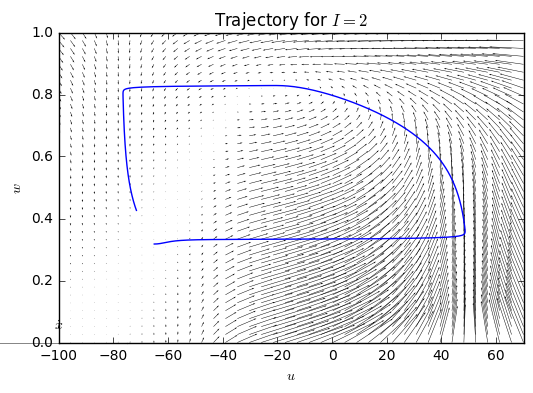

In [85]:
def trajectory_plot(ϵ = 0.1, b0 = 2., b1 = 1.5, I = 1):
    U, W = np.meshgrid(np.linspace(-100, 70, 40), np.linspace(0, 1, 40))
    dU = dudt(U,W,I)
    dW = dwdt(U,W)

        
    print(dW.max(), dU.max())
    
    dW /= dW.max()
    dU /= dU.max()


    # Quiver Plot
    plt.figure()
    Q = plt.quiver(U,W,dU, dW, width=0.001, scale=10)
    qk = plt.quiverkey(Q, 0, 0, 3, r'$\dot x$', labelpos='N',
                       fontproperties={'weight': 'bold'})
    l, r, b, t = plt.axis()
    dx, dy = r - l, t - b
    plt.axis([-100,70,0,1])

    # Trajectory
    uu, ww = compute(I*np.ones((10000,)),0.001)
    plt.plot(uu, ww)

    plt.xlabel(r"$u$")
    plt.ylabel(r"$w$")
    
trajectory_plot(I=2)
plt.title(r"Trajectory for $I=2$")
plt.show()

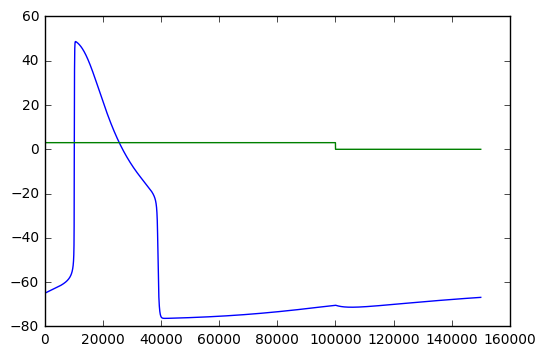

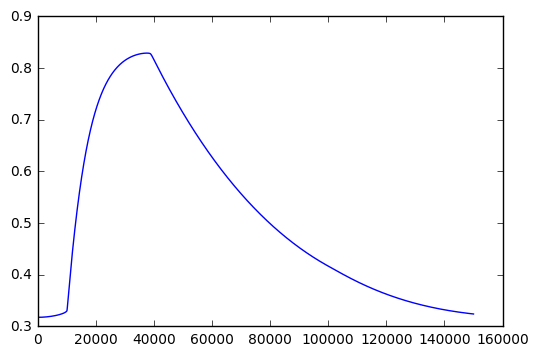

In [86]:
step_on =  0
step_off = 10
sim_time = 15

total_time = sim_time #s
dt = 0.0001
nb_samples = int(total_time / dt)

tt = np.linspace(0, total_time, nb_samples)
I_in = np.zeros((nb_samples,))
timeslice = lambda start, end : slice(int(start/dt), int(end/dt))

i2 = 0
di = 3

I_in[timeslice(0,step_on)] = np.linspace(0, i2, step_on/dt)
I_in[timeslice(step_on,step_off)] = i2 + di

uu, ww = compute(I_in, dt)

plt.plot(uu)
plt.plot(I_in)
plt.show()

plt.plot(ww)
plt.show()